In [1]:
import zipfile
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,ParameterGrid
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GridSearchCV
import os
from torch.utils.data import TensorDataset
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import json
from sklearn.model_selection import ParameterGrid
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import copy
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
    device = torch.device("cuda")  # Select GPU device
else:
    print("CUDA is not available. Training on CPU.")
    device = torch.device("cpu")

CUDA is available. Training on GPU.


In [13]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# **Below are the functions to pre-process the data (fetching, cleaning, tokenization)**

In [7]:
def process_data(max_length=100):
    columnns = ["id", "tweet", "subtask_a", "subtask_b", "subtask_c"]

    #with zipfile.ZipFile('OlidPreprcessed.zip') as zip_f: - Used it if you run locally

    with open('/content/OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt', 'r') as f:
        df = pd.read_csv(f, sep='\t', header=None, names=columnns)

    df.drop(["id", "subtask_b", "subtask_c"], axis=1, inplace=True)
    df['subtask_a'] = df['subtask_a'].apply(lambda x: 1 if x == 'OFF' else 0)
    tweets = df['tweet'].astype(str)
    tweets_cleaned = tweets.apply(clean_text)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets_cleaned)
    vocab_size = len(tokenizer.word_index)
    sequence = tokenizer.texts_to_sequences(tweets_cleaned)

    max_length_default = max_length
    max_length_new = get_sequence_max_length(sequence)

    if max_length_new> 0 and max_length_new<max_length_default:
        max_length = max_length_new

    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

    features = np.array(padded_sequence)

    encoder = LabelEncoder()
    labels = encoder.fit_transform(df['subtask_a'])

    return features, labels, vocab_size, max_length

def process_test_data(max_length=100):
    columnns = ["id", "tweet"]

    #with zipfile.ZipFile('OlidPreprcessed.zip') as zip_f:  - Used it if you run locally
    with open('/kaggle/input/oidset/OLID_TEST_A_ATUSER_URL_EmojiRemoved_Pedro.txt', 'r') as f:
        df = pd.read_csv(f, sep='\t', header=None, names=columnns)

    df.drop(["id", "subtask_b", "subtask_c"], axis=1, inplace=True)
    df['subtask_a'] = df['subtask_a'].apply(lambda x: 1 if x == 'OFF' else 0)
    tweets = df['tweet'].astype(str)
    tweets_cleaned = tweets.apply(clean_text)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets_cleaned)
    vocab_size = len(tokenizer.word_index)
    sequence = tokenizer.texts_to_sequences(tweets_cleaned)

    max_length_default = max_length
    max_length_new = get_sequence_max_length(sequence)

    if max_length_new> 0 and max_length_new<max_length_default:
        max_length = max_length_new

    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

    features = np.array(padded_sequence)

    encoder = LabelEncoder()
    df['subtask_a'] = df.dropna(subset=['subtask_a'])
    labels = encoder.fit_transform(df['subtask_a'])

    return features, labels, vocab_size, max_length

def get_sequence_max_length(sequences):

    max_length = 0

    # Iterate through each sequence
    for sequence in sequences:
        # Calculate the length of the sequence
        length = len(sequence)

        # Update max_length if the current sequence is longer
        if length > max_length:
            max_length = length

    return max_length

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+', '', text)
    text = re.sub(r'\#\w+', '', text)
    text = re.sub(r"[^a-zA-Z']", ' ', text)  # Keep letters and apostrophes
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


In [8]:
# Define batch size
batch_size = 32

X, y,vocab_size, input_dim = process_data()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)


print(vocab_size)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Check label distribution
print("Distribution of labels in y_train:")
print(f"Count of '0' (Not Offensive): {np.sum(y_train == 0)}")
print(f"Count of '1' (Offensive): {np.sum(y_train == 1)}")

# Convert X_train and y_train to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_valid_tensor = torch.tensor(X_valid)
y_valid_tensor = torch.tensor(y_valid)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

# Create a TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=4)


18751
Shape of X_train: (9268, 63)
Shape of y_train: (9268,)
Distribution of labels in y_train:
Count of '0' (Not Offensive): 6163
Count of '1' (Offensive): 3105


# **Below is LSTM model and its training and test functions**

In [25]:
# LSTM model
class SimpleLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, output_size, dropout=0.2):
        super(SimpleLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        lstm_out = self.bn(lstm_out.permute(0, 2, 1)).permute(0, 2, 1)
        output = self.fc(ht[-1])
        return output

# Function to train the model
def train_lstm(model, train_loader,val_loader, optimizer, criterion,epochs,model_name, patience=60):
    model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float()
                outputs = model(inputs).squeeze(1)
                val_loss = criterion(outputs,labels)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Validation loss has not improved for {patience} epochs. Early stopping...')
                break


    model.load_state_dict(best_model)
    torch.save(model.state_dict(), model_name)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()



# Function to test the model
def test_lstm(model, test_loader,model_name):
    model.load_state_dict(torch.load(model_name))
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            predictions = model(inputs).squeeze(1)
            predicted_classes = (predictions >= 0.5).float()
            all_predictions.extend(predicted_classes.tolist())
            all_labels.extend(labels.tolist())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Offensive', 'Offensive'], yticklabels=['Not Offensive', 'Offensive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# **Below is BiLSTM model and its training and test functions**

In [26]:
# BiLSTM model
class Attention(nn.Module):
    """ Attention mechanism to weight the importance of different steps in the sequence. """
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(feature_dim, 1)

    def forward(self, x):
        # x.shape: (batch_size, seq_length, features)
        scores = self.attention(x).squeeze(2)  # Reduce features dimension to 1
        alpha = F.softmax(scores, dim=1).unsqueeze(2)  # Get the weights
        weighted = torch.sum(x * alpha, dim=1)  # Sum weighted features
        return weighted

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)

        # Attention Layer
        self.attention = Attention(hidden_size * 2)  # Use the concatenated output for attention

        # Batch Normalization Layer
        self.bn = nn.BatchNorm1d(hidden_size * 2)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # First dense layer
        self.fc2 = nn.Linear(hidden_size, output_size)      # Output layer

    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)

        # LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out.shape: (batch_size, seq_length, hidden_dim * 2)

        # Attention layer
        attended = self.attention(lstm_out)  # attended.shape: (batch_size, hidden_dim * 2)

        # Batch Normalization
        normalized = self.bn(attended)

        # Dropout and fully connected layers
        out = self.dropout(normalized)
        out = F.relu(self.fc1(out))  # Activation function
        out = self.fc2(out)  # Final output layer
        return out

# Function to train the model
def train_bilstm(model, train_loader,val_loader, optimizer, criterion,epochs,model_name, patience=60):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                #labls = torch.nn.functional.one_hot(labels, num_classes=2)
                labels = labels.to(device).float()
                outputs = model(inputs)
                val_loss = criterion(outputs.squeeze(),labels)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Validation loss has not improved for {patience} epochs. Early stopping...')
                break

    model.load_state_dict(best_model)
    torch.save(model.state_dict(), model_name)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()



# Function to test the model
def test_bilstm(model, test_loader,model_name):
    model.load_state_dict(torch.load(model_name))
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            predictions = model(inputs).squeeze(1)
            predicted_classes = (predictions >= 0.5).float()
            all_predictions.extend(predicted_classes.tolist())
            all_labels.extend(labels.tolist())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Offensive', 'Offensive'], yticklabels=['Not Offensive', 'Offensive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# **Here we prepare fucntions fo grid search**

In [11]:
def create_loaders(batch_size):
    X, y,vocab_size, input_dim = process_data()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)


    # Convert X_train and y_train to PyTorch tensors
    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train)
    X_valid_tensor = torch.tensor(X_valid)
    y_valid_tensor = torch.tensor(y_valid)
    X_test_tensor = torch.tensor(X_test)
    y_test_tensor = torch.tensor(y_test)

    # Create a TensorDataset
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=4)

    return train_loader,valid_loader,test_loader

class EarlyStopping:
    def __init__(self, patience=30, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''

        torch.save(model.state_dict(), 'best_model.pt')
        self.val_loss_min = val_loss


def train_evaluate(model, train_loader, val_loader, epochs, learning_rate, criterion_name,optimizer_name,momentum=None, alpha=0.99, patience=20,weight_decay=0.9):

    optimizer = get_optimizer(model, optimizer_name, learning_rate, momentum)
    for param_group in optimizer.param_groups:
        param_group['weight_decay'] = weight_decay

    scheduler = ReduceLROnPlateau(optimizer, 'min')

    criterion = get_criterion(criterion_name)
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(1), labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float()
                outputs = model(inputs)
                val_loss += criterion(outputs.squeeze(1), labels).item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            break

    model.load_state_dict(torch.load('best_model.pt'))  # Load the last best model
    return val_loss,model

def get_optimizer(model, optimizer_name, learning_rate, momentum=None, alpha=0.99):
    if optimizer_name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    elif optimizer_name == 'rmsprop':
        return torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=alpha)
    else:
        raise ValueError("Unsupported optimizer: {}".format(optimizer_name))

def get_criterion(name):
    if name == 'bce_logits':
        return torch.nn.BCEWithLogitsLoss()
    elif name == 'cross_entropy':
        return torch.nn.CrossEntropyLoss()
    else:
        raise ValueError("Unsupported loss function: {}".format(name))


# **Here we conduct a grid search for the (standard) LSTM model, followed by training and model enhancement**

In [15]:
param_grid = {
    'embedding_dim': [100,200],
    'hidden_size': [128, 256],
    'num_layers': [2,4],
    'dropout': [0.3,0.5],
    'optimizer': ['adam'],
    'criterion': ['bce_logits'],
    'epochs': [200],
    'learning_rate': [0.0001, 0.001],
    'batch_size': [32,64]
}

# Instantiate the grid of parameters
param_grid = ParameterGrid(param_grid)

# Storage for results
results = []
best_val_loss = float('inf')

i =1
for params in param_grid:
    # __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, output_size, dropout=0.2):
    model = SimpleLSTMModel(vocab_size=vocab_size+ 1, embedding_dim=params['embedding_dim'],hidden_size=params['hidden_size'], dropout=params['dropout'], num_layers=params['num_layers'], output_size=1)
    if torch.cuda.device_count() > 1:
        # This wrapper handles the distribution of data to and gathering from the GPUs
        model = nn.DataParallel(model)

    train_loader, val_loader,_ = create_loaders(params['batch_size'])

    momentum=params.get('momentum', 0)
    alpha=params.get('alpha', 0.99)
    val_loss,best_model = train_evaluate(model, train_loader, val_loader, epochs=params['epochs'], learning_rate=params['learning_rate'],optimizer_name=params['optimizer'],criterion_name=params['criterion'],momentum=momentum,alpha=alpha)

    with open('lstm_validation_results.txt', 'a') as f:
        f.write(f"Experiment {i}: Params: {json.dumps(params)}, Validation Loss: {val_loss}\n")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        print("New best validation loss:", best_val_loss)
        print(f"New Best Model (number {i}) Parameters: {params}")
        # Save the model state
        torch.save(best_model.state_dict(), 'best_lstm_model.pth')

    i = i +1
# Output final results
print("Final Best Validation Loss:", best_val_loss)
print("Best Parameters:", best_params)

New best validation loss: 0.6711720152506753
New Best Model (number 1) Parameters: {'batch_size': 32, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 100, 'epochs': 200, 'hidden_size': 128, 'learning_rate': 0.0001, 'num_layers': 2, 'optimizer': 'adam'}
New best validation loss: 0.6700706131874569
New Best Model (number 2) Parameters: {'batch_size': 32, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 100, 'epochs': 200, 'hidden_size': 128, 'learning_rate': 0.0001, 'num_layers': 4, 'optimizer': 'adam'}
New best validation loss: 0.6690248742936149
New Best Model (number 3) Parameters: {'batch_size': 32, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 100, 'epochs': 200, 'hidden_size': 128, 'learning_rate': 0.001, 'num_layers': 2, 'optimizer': 'adam'}
New best validation loss: 0.6689966671050541
New Best Model (number 10) Parameters: {'batch_size': 32, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 200, 'epochs': 200, 'hidden_size': 128, 'le

# **Traing and testing the 1st best LSTM model**

In [22]:
embedding_dim = 200
hidden_size = 256
num_layers = 4
output_size = 1
dropout = 0.3
learning_rate = 0.0001
criterion_name = 'bce_logits'
optimizer_name= 'adam'
momentum = 0.9
epochs = 300
weight_decay=0.001
batch_size = 64

model_simple_lstm_1 = SimpleLSTMModel(vocab_size +1, embedding_dim, hidden_size, num_layers, output_size, dropout)
model_simple_lstm_1.to(device)
model_name = 'model_simple_lstm_1'

optimizer = get_optimizer(model_simple_lstm_1, optimizer_name, learning_rate, momentum)
for param_group in optimizer.param_groups:
    param_group['weight_decay'] = weight_decay

criterion = get_criterion(criterion_name)

train_loader,valid_loader,test_loader = create_loaders(batch_size)

Epoch 10/300, Training Loss: 0.6053, Validation Loss: 0.4011
Epoch 20/300, Training Loss: 0.7288, Validation Loss: 0.3646
Epoch 30/300, Training Loss: 0.5925, Validation Loss: 0.4056
Epoch 40/300, Training Loss: 0.5588, Validation Loss: 0.7644
Epoch 50/300, Training Loss: 0.6452, Validation Loss: 0.7482
Epoch 60/300, Training Loss: 0.7221, Validation Loss: 0.4157
Epoch 70/300, Training Loss: 0.7018, Validation Loss: 0.7580
Epoch 80/300, Training Loss: 0.6573, Validation Loss: 0.4233
Validation loss has not improved for 60 epochs. Early stopping...


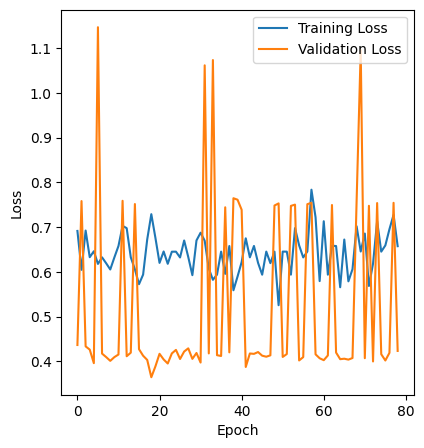

In [27]:
train_lstm(model_simple_lstm_1, train_loader,valid_loader, optimizer, criterion,epochs,model_name)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.6668


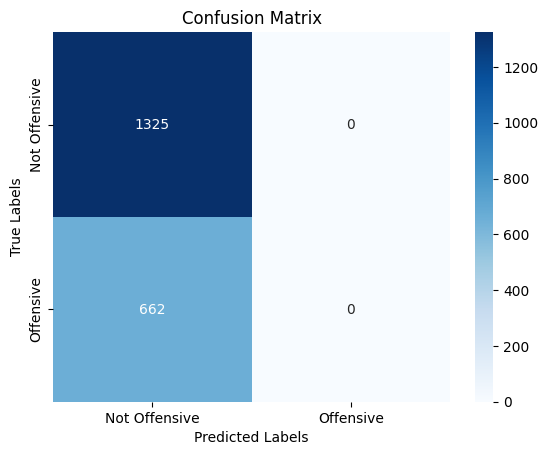

In [28]:
test_lstm(model_simple_lstm_1, test_loader,model_name)

# **Now we try to enhance result by overcoming data imbalance**

In [29]:
# Adding class weights to overcome data imbalance
embedding_dim = 200
hidden_size = 256
num_layers = 4
output_size = 1
dropout = 0.3
learning_rate = 0.0001
criterion_name = 'bce_logits'
optimizer_name= 'adam'
momentum = 0.9
epochs = 300
weight_decay=0.001
batch_size = 64

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y),y= y)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

model_simple_lstm_1_cw = SimpleLSTMModel(vocab_size +1, embedding_dim, hidden_size, num_layers, output_size, dropout)
model_simple_lstm_1_cw.to(device)
model_name = 'model_simple_lstm_1_cw'

optimizer = get_optimizer(model_simple_lstm_1_cw, optimizer_name, learning_rate, momentum)
# Update the weights in the optimizer
for param_group in optimizer.param_groups:
    param_group['weight_decay'] = weight_decay
    param_group['weight'] = class_weights_tensor

criterion = get_criterion(criterion_name)

Epoch 10/300, Training Loss: 0.6085, Validation Loss: 0.4247
Epoch 20/300, Training Loss: 0.6842, Validation Loss: 1.0924
Epoch 30/300, Training Loss: 0.6825, Validation Loss: 0.4186
Epoch 40/300, Training Loss: 0.5914, Validation Loss: 0.7554
Epoch 50/300, Training Loss: 0.7127, Validation Loss: 0.4061
Epoch 60/300, Training Loss: 0.7061, Validation Loss: 0.7426
Validation loss has not improved for 60 epochs. Early stopping...


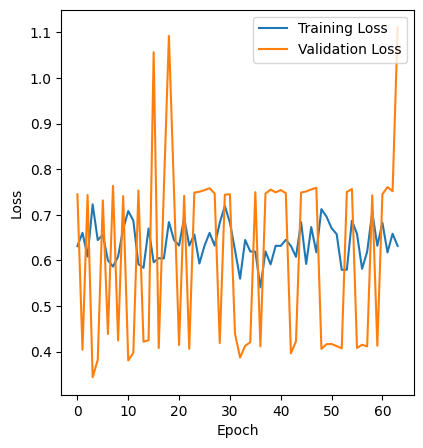

In [30]:
train_lstm(model_simple_lstm_1_cw, train_loader,valid_loader, optimizer, criterion,epochs,model_name)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.6668


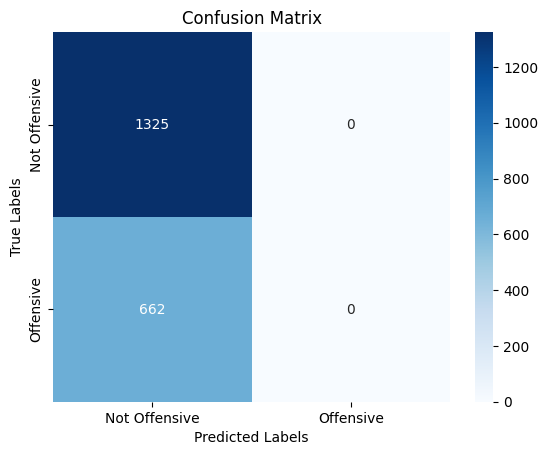

In [31]:
test_lstm(model_simple_lstm_1_cw, test_loader,model_name)

In [42]:
# Adding more layers
embedding_dim = 300
hidden_size = 512
num_layers = 4
output_size = 1
dropout = 0.3
learning_rate = 0.0001
criterion_name = 'bce_logits'
optimizer_name= 'adam'
momentum = 0.9
epochs = 300
weight_decay=0.001
batch_size = 64

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y),y= y)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

model_simple_lstm_2_cw = SimpleLSTMModel(vocab_size +1, embedding_dim, hidden_size, num_layers, output_size, dropout)
model_simple_lstm_2_cw.to(device)
model_name = 'model_simple_lstm_2_cw'

optimizer = get_optimizer(model_simple_lstm_2_cw, optimizer_name, learning_rate, momentum)
# Update the weights in the optimizer
for param_group in optimizer.param_groups:
    param_group['weight_decay'] = weight_decay
    param_group['weight'] = class_weights_tensor

criterion = get_criterion(criterion_name)

Epoch 10/300, Training Loss: 0.6357, Validation Loss: 0.7286
Epoch 20/300, Training Loss: 0.6212, Validation Loss: 0.4278
Epoch 30/300, Training Loss: 0.6999, Validation Loss: 0.4014
Epoch 40/300, Training Loss: 0.7000, Validation Loss: 0.4024
Epoch 50/300, Training Loss: 0.5948, Validation Loss: 0.4176
Epoch 60/300, Training Loss: 0.6322, Validation Loss: 0.7497
Epoch 70/300, Training Loss: 0.6459, Validation Loss: 0.7583
Epoch 80/300, Training Loss: 0.6320, Validation Loss: 0.7573
Epoch 90/300, Training Loss: 0.5775, Validation Loss: 0.7550
Epoch 100/300, Training Loss: 0.6329, Validation Loss: 0.4254
Validation loss has not improved for 60 epochs. Early stopping...


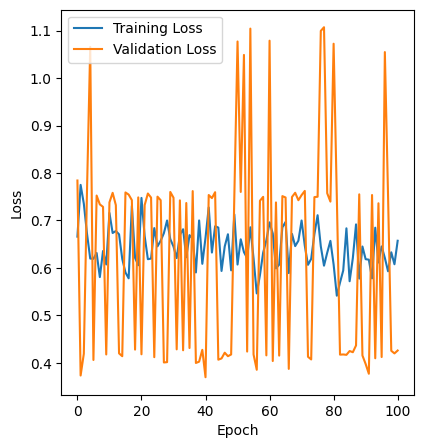

In [43]:
train_lstm(model_simple_lstm_2_cw, train_loader,valid_loader, optimizer, criterion,epochs,model_name)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.6668


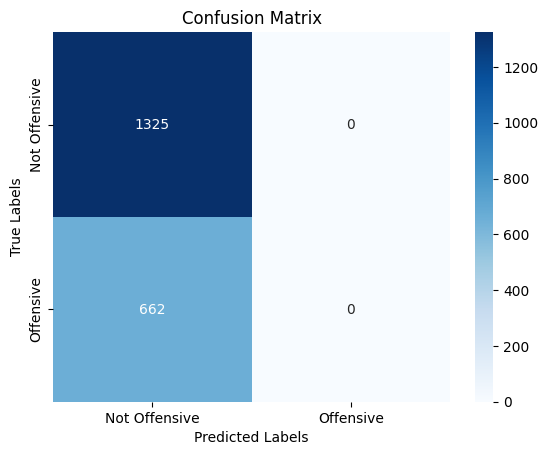

In [44]:
test_lstm(model_simple_lstm_2_cw, test_loader,model_name)

# **Here we conduct a grid search for the BiLSTM model, followed by training and model enhancement**

In [17]:
param_grid = {
    'embedding_dim': [100,200],
    'hidden_size': [128, 256],
    'num_layers': [2, 4],
    'dropout': [0.3,0.5],
    'optimizer': ['adam'],
    'criterion': ['bce_logits'],
    'epochs': [300],
    'learning_rate': [0.0001, 0.001],
    'batch_size': [32, 64]
}

# Instantiate the grid of parameters
param_grid = ParameterGrid(param_grid)

# Storage for results
best_val_loss = float('inf')
i = 1
for params in param_grid:
    #BiLSTMModel(vocab_size +1, embedding_dim, hidden_size, output_size,num_layers,dropout)
    model = BiLSTMModel(vocab_size=vocab_size+ 1, embedding_dim=params['embedding_dim'],hidden_size=params['hidden_size'], dropout=params['dropout'], num_layers=params['num_layers'], output_size=1)
    if torch.cuda.device_count() > 1:
        # This wrapper handles the distribution of data to and gathering from the GPUs
        model = nn.DataParallel(model)
    train_loader, val_loader,_ = create_loaders(params['batch_size'])  # Assume a function that creates data loaders
    momentum=params.get('momentum', 0)
    alpha=params.get('alpha', 0.99)
    val_loss,best_model = train_evaluate(model, train_loader, val_loader, epochs=params['epochs'], learning_rate=params['learning_rate'],optimizer_name=params['optimizer'],criterion_name=params['criterion'],momentum=momentum,alpha=alpha)
    with open('bilstm_validation_results.txt', 'a') as f:
        f.write(f"Experiment {i}: Params: {json.dumps(params)}, Validation Loss: {val_loss}\n")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        print("New best validation loss:", best_val_loss)
        print(f"New Best Model (number {i}) Parameters: {params}")
        # Save the model state
        torch.save(best_model.state_dict(), 'best_bilstm_model.pth')
    i = i +1
# Output final results
print("Final Best Validation Loss:", best_val_loss)
print("Best Parameters:", best_params)


New best validation loss: 0.6699137299779861
New Best Model (number 1) Parameters: {'batch_size': 32, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 100, 'epochs': 300, 'hidden_size': 128, 'learning_rate': 0.0001, 'num_layers': 2, 'optimizer': 'adam'}
New best validation loss: 0.6690585499718076
New Best Model (number 4) Parameters: {'batch_size': 32, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 100, 'epochs': 300, 'hidden_size': 128, 'learning_rate': 0.001, 'num_layers': 4, 'optimizer': 'adam'}
New best validation loss: 0.669002926538861
New Best Model (number 8) Parameters: {'batch_size': 32, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 100, 'epochs': 300, 'hidden_size': 256, 'learning_rate': 0.001, 'num_layers': 4, 'optimizer': 'adam'}
New best validation loss: 0.6689976236176869
New Best Model (number 12) Parameters: {'batch_size': 32, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 200, 'epochs': 300, 'hidden_size': 128, 'lear

# **Traing and testing the 1st best BiLSTM model**

In [33]:
embedding_dim = 200
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.5
learning_rate = 0.001
criterion_name = 'bce_logits'
optimizer_name= 'adam'
batch_size = 64
epochs = 300

model_simple_bilstm_1 = BiLSTMModel(vocab_size +1, embedding_dim, hidden_size, output_size,num_layers,dropout)
model_simple_bilstm_1.to(device)
model_name = 'model_simple_bilstm_1'
optimizer = get_optimizer(model_simple_bilstm_1, optimizer_name, learning_rate, momentum)
criterion = get_criterion(criterion_name)

train_loader,valid_loader,test_loader = create_loaders(batch_size)

Epoch 10/300, Training Loss: 0.0352, Validation Loss: 6.9625
Epoch 20/300, Training Loss: 0.0586, Validation Loss: 5.9191
Epoch 30/300, Training Loss: 0.0047, Validation Loss: 5.8625
Epoch 40/300, Training Loss: 0.0132, Validation Loss: 0.0000
Epoch 50/300, Training Loss: 0.0070, Validation Loss: 7.9397
Epoch 60/300, Training Loss: 0.0000, Validation Loss: 0.4720
Epoch 70/300, Training Loss: 0.0022, Validation Loss: 1.0886
Epoch 80/300, Training Loss: 0.0147, Validation Loss: 16.0580
Epoch 90/300, Training Loss: 0.0124, Validation Loss: 0.0004
Epoch 100/300, Training Loss: 0.0208, Validation Loss: 0.2437
Epoch 110/300, Training Loss: 0.0017, Validation Loss: 9.4631
Epoch 120/300, Training Loss: 0.0000, Validation Loss: 5.6449
Epoch 130/300, Training Loss: 0.0021, Validation Loss: 0.0000
Epoch 140/300, Training Loss: 0.0056, Validation Loss: 0.0001
Epoch 150/300, Training Loss: 0.0002, Validation Loss: 0.0000
Epoch 160/300, Training Loss: 0.0291, Validation Loss: 5.2909
Epoch 170/300, T

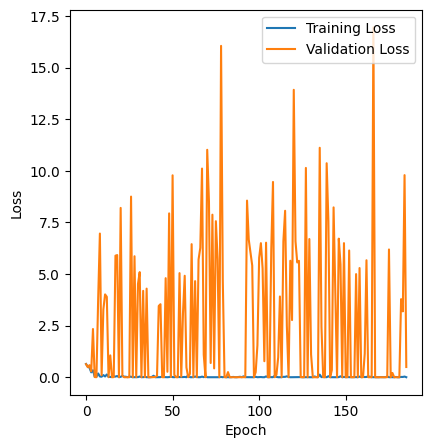

In [34]:
train_bilstm(model_simple_bilstm_1, train_loader,valid_loader, optimizer, criterion,epochs,model_name)

Precision: 0.5973
Recall: 0.5332
F1 Score: 0.5634
Accuracy: 0.7247


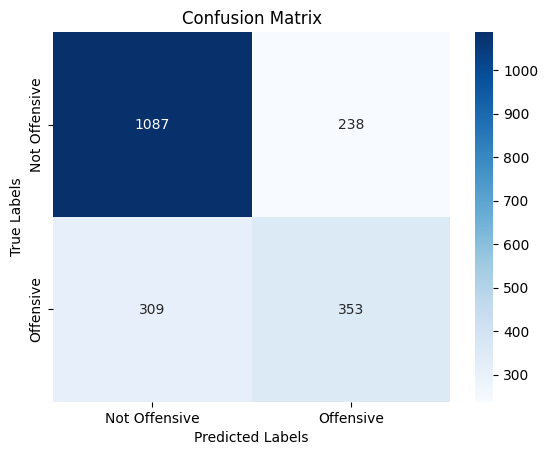

In [35]:
test_bilstm(model_simple_bilstm_1, test_loader,model_name)

# **Now we try to enhance result by overcoming data imbalance**

In [36]:
# Adding class weights to overcome data imbalance
embedding_dim = 200
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.5
learning_rate = 0.001
criterion_name = 'bce_logits'
optimizer_name= 'adam'
batch_size = 64
epochs = 300

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y),y= y)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

model_simple_bilstm_1_cw = BiLSTMModel(vocab_size +1, embedding_dim, hidden_size, output_size,num_layers,dropout)
model_simple_bilstm_1_cw.to(device)
model_name = 'model_simple_bilstm_1_cw'

optimizer = get_optimizer(model_simple_bilstm_1_cw, optimizer_name, learning_rate, momentum)
for param_group in optimizer.param_groups:
    param_group['weight'] = class_weights_tensor

criterion = get_criterion(criterion_name)

train_loader,valid_loader,test_loader = create_loaders(batch_size)

Epoch 10/300, Training Loss: 0.3243, Validation Loss: 4.5541
Epoch 20/300, Training Loss: 0.0139, Validation Loss: 0.0012
Epoch 30/300, Training Loss: 0.0203, Validation Loss: 1.8905
Epoch 40/300, Training Loss: 0.0032, Validation Loss: 0.0000
Epoch 50/300, Training Loss: 0.0135, Validation Loss: 16.1392
Epoch 60/300, Training Loss: 0.0158, Validation Loss: 0.0002
Epoch 70/300, Training Loss: 0.0002, Validation Loss: 0.0002
Epoch 80/300, Training Loss: 0.0000, Validation Loss: 6.5989
Epoch 90/300, Training Loss: 0.0378, Validation Loss: 12.8485
Epoch 100/300, Training Loss: 0.0111, Validation Loss: 5.3719
Epoch 110/300, Training Loss: 0.0041, Validation Loss: 0.0001
Epoch 120/300, Training Loss: 0.0031, Validation Loss: 0.0383
Epoch 130/300, Training Loss: 0.0548, Validation Loss: 0.0014
Validation loss has not improved for 60 epochs. Early stopping...


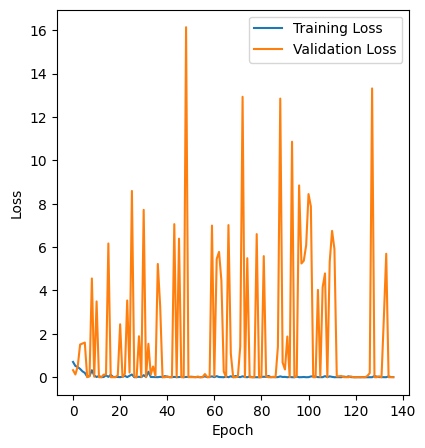

In [37]:
train_bilstm(model_simple_bilstm_1_cw, train_loader,valid_loader, optimizer, criterion,epochs,model_name)

Precision: 0.6284
Recall: 0.4879
F1 Score: 0.5493
Accuracy: 0.7333


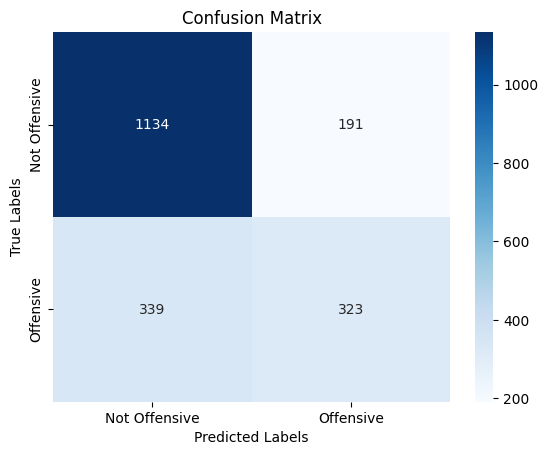

In [38]:
test_bilstm(model_simple_bilstm_1_cw, test_loader,model_name)

In [45]:
# Adding more layers
embedding_dim = 300
hidden_size = 512
num_layers = 4
output_size = 1
dropout = 0.5
learning_rate = 0.001
criterion_name = 'bce_logits'
optimizer_name= 'adam'
batch_size = 128
epochs = 300

class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y),y= y)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

model_simple_bilstm_2_cw = BiLSTMModel(vocab_size +1, embedding_dim, hidden_size, output_size,num_layers,dropout)
model_simple_bilstm_2_cw.to(device)
model_name = 'model_simple_bilstm_2_cw'

optimizer = get_optimizer(model_simple_bilstm_2_cw, optimizer_name, learning_rate, momentum)
for param_group in optimizer.param_groups:
    param_group['weight'] = class_weights_tensor

criterion = get_criterion(criterion_name)

train_loader,valid_loader,test_loader = create_loaders(batch_size)

Epoch 10/300, Training Loss: 0.1488, Validation Loss: 0.9859
Epoch 20/300, Training Loss: 0.0004, Validation Loss: 1.4559
Epoch 30/300, Training Loss: 0.1537, Validation Loss: 2.3929
Epoch 40/300, Training Loss: 0.0000, Validation Loss: 3.6375
Epoch 50/300, Training Loss: 0.0246, Validation Loss: 2.2834
Epoch 60/300, Training Loss: 0.0000, Validation Loss: 1.4114
Epoch 70/300, Training Loss: 0.0052, Validation Loss: 1.1278
Epoch 80/300, Training Loss: 0.0124, Validation Loss: 1.2552
Epoch 90/300, Training Loss: 0.0393, Validation Loss: 0.9156
Validation loss has not improved for 60 epochs. Early stopping...


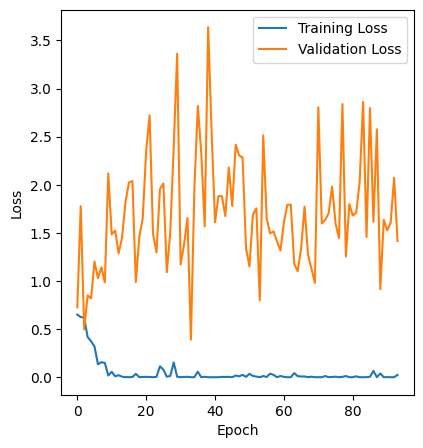

In [46]:
train_bilstm(model_simple_bilstm_2_cw, train_loader,valid_loader, optimizer, criterion,epochs,model_name)

Precision: 0.5694
Recall: 0.5393
F1 Score: 0.5539
Accuracy: 0.7106


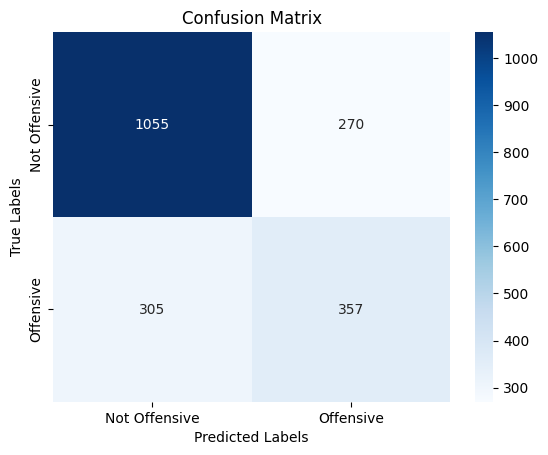

In [47]:
test_bilstm(model_simple_bilstm_2_cw, test_loader,model_name)

# Here we develop and train BERT model

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

columnns = ["id", "tweet", "subtask_a", "subtask_b", "subtask_c"]

#with zipfile.ZipFile('OlidPreprcessed.zip') as zip_f: - Used it if you run locally
with open('/kaggle/input/oidset/OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt', 'r') as f:
    df = pd.read_csv(f, sep='\t', header=None, names=columnns)

df.drop(["id", "subtask_b", "subtask_c"], axis=1, inplace=True)
df['subtask_a'] = df['subtask_a'].apply(lambda x: 1 if x == 'OFF' else 0)
tweets = df['tweet'].astype(str)
tweets_cleaned = tweets.apply(clean_text).tolist()

encoder = LabelEncoder()
labels = encoder.fit_transform(df['subtask_a'].tolist())


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X = tokenizer(tweets_cleaned, padding=True, truncation=True, return_tensors='pt')


#X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.3, random_state=42)

train_dataset = torch.utils.data.TensorDataset(X['input_ids'],
                                               X['attention_mask'],
                                               torch.tensor(labels))
val_dataset = torch.utils.data.TensorDataset(X['input_ids'],
                                             X['attention_mask'],
                                             torch.tensor(labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=4)


In [ ]:
num_epochs = 100

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
if torch.cuda.device_count() > 1:
        # This wrapper handles the distribution of data to and gathering from the GPUs
        model = nn.DataParallel(model)

model.to(device)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits,labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set
    model.eval()
    val_preds = []
    val_true = []
    for batch in val_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_true, val_preds)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Accuracy: {val_accuracy:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scal

Epoch [10/100], Val Accuracy: 0.9964


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

KeyboardInterrupt: 